Vitals Correlations

In [8]:
# Import Modules

import sys
sys.path.append("..") #give this script access to all modules in parent directory
import os
from pathlib import Path
import matplotlib.lines as mlines
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math

# Import Statistical Tests and tsfel
from scipy.io import loadmat
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
import tsfel
from operator import itemgetter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import statistics

# Import Previous Scripts
import Filtering
import Correlations


Correlation Function using TSFEL

In [14]:
def pearson_corr_vitals_sbs(signal, sbs, signal_name, lead_time, slice_size_min, patient):
    '''
    @param signal: vitals signal input
    @param sbs: sbs corresponding to vitals signal
    @param signal_name: name of input signal
    '''
    # Assuming tsfel and other necessary imports are already done

    cfg_file = tsfel.get_features_by_domain()
    features_list = []
    sbs_list = []
    fs = .5
    
    # Assuming signal and sbs are lists
    for i in range(len(signal)):
        if np.mean(np.array(signal[i])) != 0: #check for flag list
            sbs_list.append(sbs[i])
            features = tsfel.time_series_features_extractor(cfg_file, signal[i], fs, verbose=0)
            features_list.append(features) #vertically concatenate features data frame
        else: 
            print(f'flag list detected for {signal_name} at sbs index {i} for {patient}, window ignored')

    print(f'Number of extracted features: {len(list(features_list[0]))}')

    #list comprehension for column names
    columns = [col for col in list(features_list[0])]
    #Reshape data frame
    features_array = np.array(features_list).reshape(-1, len(columns)) 
    df_features = pd.DataFrame(features_array)

    df_features.columns = columns

    #Pearson Correlation Coefficient
    CCoeff = []
    for i in columns:
        y = sbs_list
        myX = list(df_features[i])

        #remove NaN values from features list for correlation calculations
        nan_indices = [i for i, x in enumerate(myX) if math.isnan(x)]
        myX = [x for x in myX if not math.isnan(x)]
        cleaned_y = [val for idx, val in enumerate(y) if idx not in nan_indices]

        #check that more than two values remain and calculate correlation
        if len(myX) == len(cleaned_y) and len(myX)>=2:
            corr, _ = pearsonr(cleaned_y, myX)
            CCoeff.append(np.abs(corr)) #append correlation coefficients for every feature to a single list, ordered by column from df_features
        else:
            print(f'not enough data for a metric for {signal_name} for patient {patient}')

    my_dict = dict(zip(list(columns), list(CCoeff)))


    # functional
    clean_dict = filter(lambda k: not math.isnan(my_dict[k]), my_dict) #remove NaN again just in case pearson failed for some metrics
    # dict comprehension
    clean_dict = {k: my_dict[k] for k in my_dict if not math.isnan(my_dict[k])}

    #Retrieve N features with best correlation coefficient  
    # Initialize N
    N = 5
            
    # N largest values in dictionary
    res = dict(sorted(clean_dict.items(), key=itemgetter(1), reverse=True)[:N])

    # printing result
    print("The top N value pairs are " + str(res))
    
    # Filter out FFT mean coefficients
    substring = '0_FFT mean coefficient'
    keys_to_delete = [key for key in res if substring in key]

    # Delete the keys
    for key in keys_to_delete:
        del res[key]

    #Plot a histogram
    y = list(res.keys())
    x = list(res.values()) #price
    
    if(len(y) == 0):
        print(f'No correlations calculated for {signal_name} for patient {patient}')
    else:
        if len(x) != 0:
            # Figure Size
            fig, ax = plt.subplots(figsize =(10 ,5))

            # Horizontal Bar Plot
            ax.barh(y, x)
            
            # Remove axes splines
            for s in ['top', 'bottom', 'left', 'right']:
                ax.spines[s].set_visible(False)
            
            # Remove x, y Ticks
            ax.xaxis.set_ticks_position('none')
            ax.yaxis.set_ticks_position('none')
            
            # Add padding between axes and labels
            ax.xaxis.set_tick_params(pad = 5)
            ax.yaxis.set_tick_params(pad = 10)
            
            # Add x, y gridlines
            ax.grid(color ='grey',
                    linestyle ='-.', linewidth = 0.5,
                    alpha = 0.2)

            # Show top values 
            ax.invert_yaxis()

            #set x axis range
            ax.set_xlim([.8*min(x),1.1*max(x)])
            # Add Plot Title
            ax.set_title(f'Correlation between top features and SBS for\n {patient}_{lead_time}MIN_{slice_size_min - lead_time}MIN {signal_name})',
                                loc ='left', )
                    
            # Show Plot

            plt.show()
                    

In [15]:
# Set Parameters
data_dir = 'C:/Users/sidha/OneDrive/Sid Stuff/PROJECTS/iMEDS Design Team/Data Analysis/PedAccel/data_analysis/PythonPipeline/PatientData'
# data_dir = r'C:\Users\jakes\Documents\DT 6 Analysis\PythonCode\PedAccel\data_analysis\PythonPipeline\PatientData'
slice_size_min = 15
lead_time = 10
sr = .5

ProcessingPatient2
Accelerometry Correlations: 
Number of extracted features: 389
The top N value pairs are {'0_FFT mean coefficient_147': 0.5708925415835802, '0_FFT mean coefficient_49': 0.5662328508044673, '0_FFT mean coefficient_123': 0.561943797235531, '0_FFT mean coefficient_255': 0.5618186191200486, '0_FFT mean coefficient_125': 0.5608689304293754}


c:\Users\sidha\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


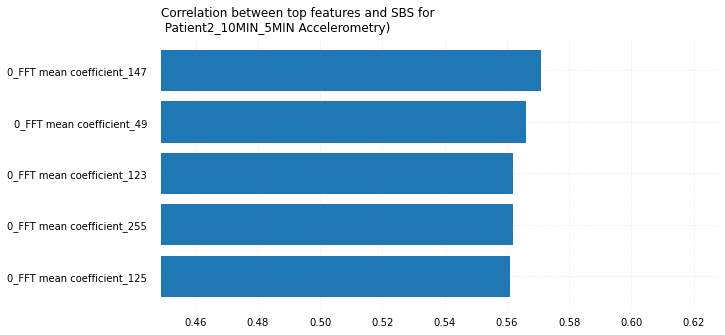

Processing Vitals Data: 
original hr vitals array shape: (30, 450) 
hr SBS index 24 has insufficient data, zeros appended in place
hr SBS index 25 has insufficient data, zeros appended in place
hr SBS index 27 has insufficient data, zeros appended in place
final hr vitals array shape: (30, 450)
original rr vitals array shape: (30, 450) 
rr SBS index 4 has insufficient data, zeros appended in place
rr SBS index 7 has insufficient data, zeros appended in place
rr SBS index 8 has insufficient data, zeros appended in place
rr SBS index 11 has insufficient data, zeros appended in place
rr SBS index 12 has insufficient data, zeros appended in place
rr SBS index 13 has insufficient data, zeros appended in place
rr SBS index 16 has insufficient data, zeros appended in place
rr SBS index 23 has insufficient data, zeros appended in place
rr SBS index 24 has insufficient data, zeros appended in place
rr SBS index 25 has insufficient data, zeros appended in place
rr SBS index 26 has insufficient d

c:\Users\sidha\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


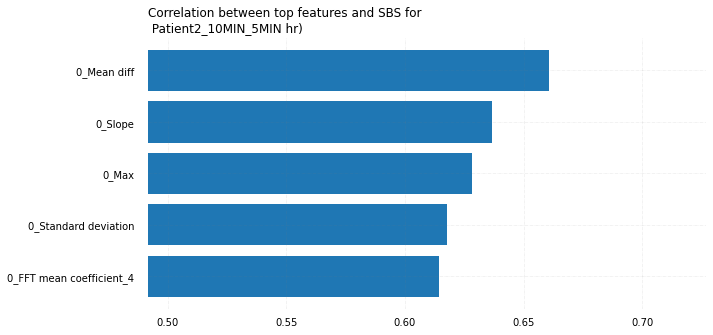

flag list detected for rr at sbs index 4 for Patient2, window ignored
flag list detected for rr at sbs index 7 for Patient2, window ignored
flag list detected for rr at sbs index 8 for Patient2, window ignored
flag list detected for rr at sbs index 11 for Patient2, window ignored
flag list detected for rr at sbs index 12 for Patient2, window ignored
flag list detected for rr at sbs index 13 for Patient2, window ignored
flag list detected for rr at sbs index 16 for Patient2, window ignored
flag list detected for rr at sbs index 23 for Patient2, window ignored
flag list detected for rr at sbs index 24 for Patient2, window ignored
flag list detected for rr at sbs index 25 for Patient2, window ignored
flag list detected for rr at sbs index 26 for Patient2, window ignored
flag list detected for rr at sbs index 27 for Patient2, window ignored
flag list detected for rr at sbs index 29 for Patient2, window ignored
Number of extracted features: 359
The top N value pairs are {'0_FFT mean coeffic

c:\Users\sidha\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


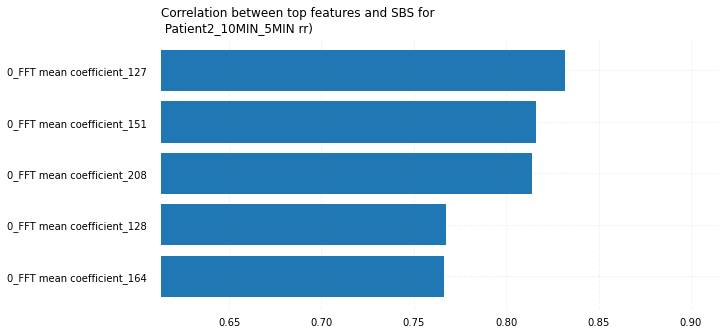

flag list detected for spo2 at sbs index 0 for Patient2, window ignored
flag list detected for spo2 at sbs index 6 for Patient2, window ignored
flag list detected for spo2 at sbs index 27 for Patient2, window ignored
Number of extracted features: 359


c:\Users\sidha\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


The top N value pairs are {'0_FFT mean coefficient_12': 0.609930323744005, '0_FFT mean coefficient_14': 0.5464008474852177, '0_FFT mean coefficient_13': 0.540632704729482, '0_FFT mean coefficient_33': 0.5394239647473839, '0_FFT mean coefficient_41': 0.5377613191237506}


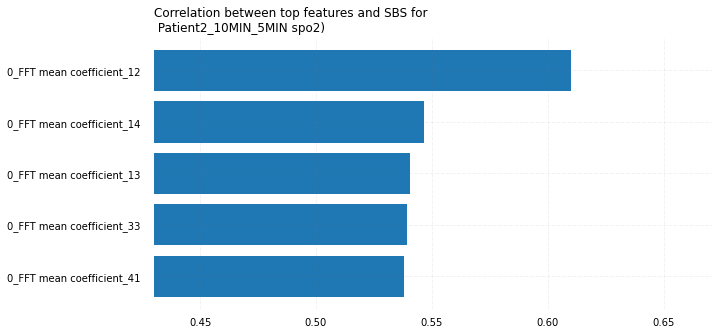

flag list detected for bpm at sbs index 13 for Patient2, window ignored
Number of extracted features: 359
The top N value pairs are {'0_Fundamental frequency': 0.3595539192461764, '0_ECDF Percentile Count_1': 0.35820056121645094, '0_Entropy': 0.3403106955240599, '0_Spectral entropy': 0.33754579923585126, '0_Autocorrelation': 0.3288451080422945}


c:\Users\sidha\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


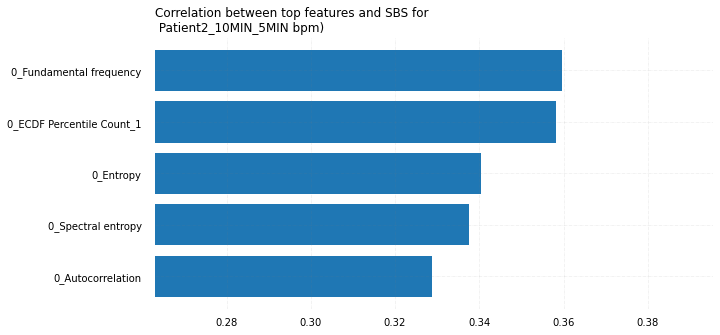

Number of extracted features: 359
The top N value pairs are {'0_Max power spectrum': 0.29239846948099046, '0_Autocorrelation': 0.2831165962977152, '0_Entropy': 0.28086252429243225, '0_ECDF Percentile Count_1': 0.2725686881025771, '0_Fundamental frequency': 0.27001747700908907}


c:\Users\sidha\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


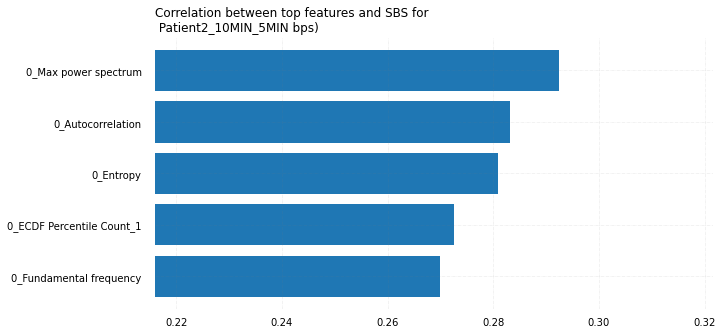

Number of extracted features: 359
The top N value pairs are {'0_Fundamental frequency': 0.3050525694963194, '0_ECDF Percentile Count_1': 0.30312775249627577, '0_Max power spectrum': 0.3029385858396726, '0_Spectral variation': 0.3004214551656189, '0_Entropy': 0.29967481608461816}


c:\Users\sidha\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


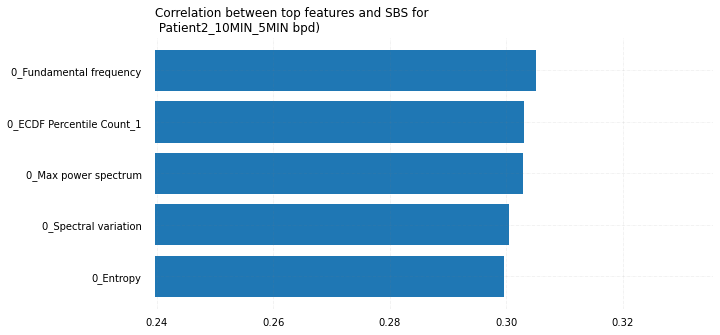

ProcessingPatient3
Accelerometry Correlations: 
Number of extracted features: 389
The top N value pairs are {'0_LPCC_5': 0.8558754836924694, '0_LPCC_7': 0.855875483692469, '0_Power bandwidth': 0.808283669127735, '0_Mean diff': 0.7947464412766986, '0_FFT mean coefficient_235': 0.7245933793436665}


c:\Users\sidha\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


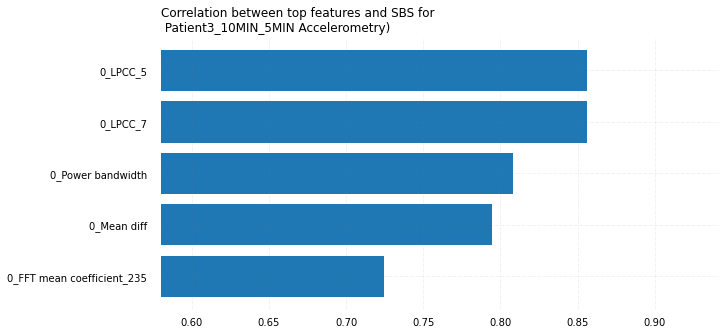

Processing Vitals Data: 
original hr vitals array shape: (11, 450) 
hr SBS index 8 has insufficient data, zeros appended in place
final hr vitals array shape: (11, 450)
original rr vitals array shape: (11, 450) 
rr SBS index 0 has insufficient data, zeros appended in place
rr SBS index 1 has insufficient data, zeros appended in place
rr SBS index 2 has insufficient data, zeros appended in place
rr SBS index 3 has insufficient data, zeros appended in place
rr SBS index 4 has insufficient data, zeros appended in place
rr SBS index 5 has insufficient data, zeros appended in place
rr SBS index 6 has insufficient data, zeros appended in place
rr SBS index 7 has insufficient data, zeros appended in place
rr SBS index 8 has insufficient data, zeros appended in place
rr SBS index 9 has insufficient data, zeros appended in place
rr SBS index 10 has insufficient data, zeros appended in place
final rr vitals array shape: (11, 450)
original spo2 vitals array shape: (11, 450) 
spo2 SBS index 8 has 

c:\Users\sidha\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


The top N value pairs are {'0_MFCC_10': 0.7401435024531395, '0_MFCC_2': 0.6385207191921799, '0_Mean diff': 0.6214807233643279, '0_MFCC_7': 0.6144034304374665, '0_FFT mean coefficient_30': 0.5882082959694523}


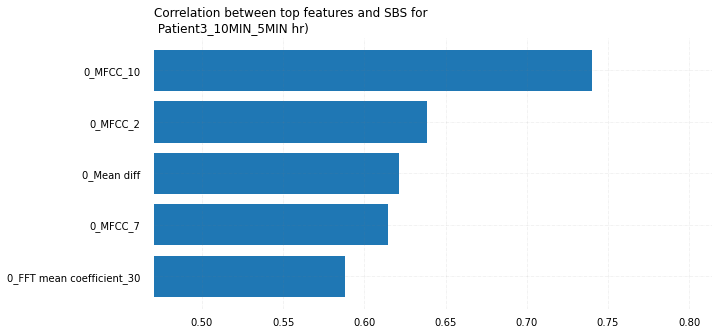

flag list detected for Patient3 for rr, all data ignored
flag list detected for spo2 at sbs index 8 for Patient3, window ignored
Number of extracted features: 359


c:\Users\sidha\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


The top N value pairs are {'0_FFT mean coefficient_165': 0.7296486990500656, '0_Signal distance': 0.7047196965825742, '0_FFT mean coefficient_215': 0.7037051445698492, '0_FFT mean coefficient_175': 0.6980960331177102, '0_FFT mean coefficient_164': 0.6918893112694043}


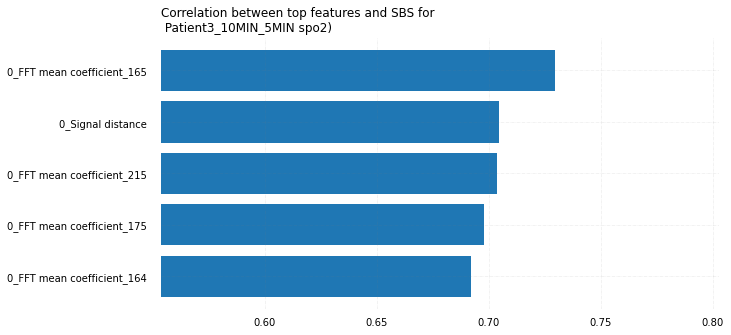

flag list detected for Patient3 for bpm, all data ignored
flag list detected for Patient3 for bps, all data ignored
flag list detected for Patient3 for bpd, all data ignored


In [16]:

#There is no error handling in place, the .mat file must exist
for patient in os.listdir(data_dir):
    # filter out non-directories
    print(f"Processing{patient}")
    patient_dir = os.path.join(data_dir, patient)
    if os.path.isdir(patient_dir):
        data_filepath_accel = os.path.join(patient_dir, f'{patient}_{lead_time}MIN_{slice_size_min - lead_time}MIN.mat')           
        data_filepath_vitals = os.path.join(patient_dir, f'{patient}_SICKBAY_{lead_time}MIN_{slice_size_min - lead_time}MIN.mat')
        
        accel_data = loadmat(data_filepath_accel)
        x_mag = accel_data["x_mag"]
        accel_SBS = accel_data["sbs"].flatten()
        
        vitals_data = loadmat(data_filepath_vitals)
        temp_hr = vitals_data['heart_rate']
        temp_SpO2 = vitals_data['SpO2']
        temp_rr = vitals_data['respiratory_rate']
        temp_bps = vitals_data['blood_pressure_systolic']
        temp_bpm = vitals_data['blood_pressure_mean']
        temp_bpd = vitals_data['blood_pressure_diastolic']
        vitals_SBS = vitals_data['sbs'].flatten()
        hr = []
        rr = []
        SpO2 = []
        bpm = []
        bps = []
        bpd = []
        vitals_list = [hr,rr,SpO2,bpm,bps,bpd]
        vitals_names = ['hr','rr','spo2','bpm','bps','bpd']
        temp_vitals = [temp_hr,temp_rr, temp_SpO2,temp_bpm,temp_bps,temp_bpd] 
        
        # Create a list to insert in place of invalid data, this list serves
        # as a flag for a window to ignore in the box plot function
        flag_list = [0] * (int)(sr * 60 * slice_size_min)

        # Accelerometry Correlations
        print("Accelerometry Correlations: ")
        accel_name = "Accelerometry"
        pearson_corr_vitals_sbs(x_mag, accel_SBS, accel_name, lead_time, slice_size_min, patient)
        
        
        
        # Vitals Correlations
        print("Processing Vitals Data: ")
        for j in range(len(vitals_list)): # Go through every vitals metric
            print(f'original {vitals_names[j]} vitals array shape: {np.array(temp_vitals[j]).shape} ')
            for i in range(len(vitals_SBS)): # Go through every SBS score for each vitals metric
                if (Filtering.checkVitals(temp_vitals[j][i], slice_size_min, vitals_names[j])): # Check the data in a single window
                    vitals_list[j].append(temp_vitals[j][i]) # Append that single window data to the 2D hr,rr,spo2,bpm,bps,bpd arrays if that window's data is valid
                else:
                    vitals_list[j].append(flag_list) # Append an array of zeros for window number i for the jth vitals metric if the data is invalid(i.e. too many NaN points)
                    print(f'{vitals_names[j]} SBS index {i} has insufficient data, zeros appended in place') 
            print(f'final {vitals_names[j]} vitals array shape: {np.array(vitals_list[j]).shape}') #should be the number of SBS scores by the number of samples in a window
        
        
        print("Vitals Correlations: ")
        for signal, name in zip(vitals_list, vitals_names): # 2D array for each vitals is input to function
            if np.mean(np.array(signal)) != 0: # Check if whole 2D array is empty
                pearson_corr_vitals_sbs(signal, vitals_SBS, name, lead_time, slice_size_min, patient)
            else:
                print(f'flag list detected for {patient} for {name}, all data ignored')